In [1]:
import numpy as np
import gymnasium as gym
from IPython.display import Video
import pickle5 as pickle
import random
import imageio
import os
import matplotlib.pyplot as plt

## FrozenLake-v1
### https://gymnasium.farama.org/environments/toy_text/frozen_lake/

In [2]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")

In [3]:
env.reset()

(0, {'prob': 1})

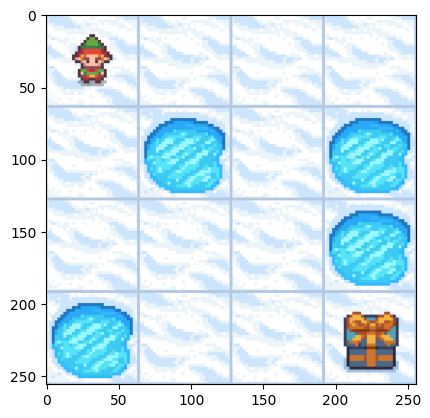

In [4]:
plt.imshow(env.render())

In [5]:
# Training parameters
env_id = "FrozenLake-v1"
n_training_episodes = 1000
alpha = 0.75
gamma = 0.95
eval_seed = []
n_eval_episodes = 1000
max_steps = 99
max_epsilon = 1
min_epsilon = 0.05
decay_rate = 0.0005

In [6]:
Q_Table = np.zeros((16, 4))

for episode in range(n_training_episodes):
    current_state, _ = env.reset()
    
    for step in range(max_steps):
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        greedy_action = np.argmax(Q_Table[current_state])
        action = greedy_action
        if np.random.rand() < epsilon:
            # Explore
            action = env.action_space.sample()
        new_state, reward, terminated, truncated, info = env.step(action)
        Q_Table[current_state][action] += alpha*(reward + gamma*np.max(Q_Table[new_state]) - Q_Table[current_state][action])
        
        if truncated or terminated:
            break
        current_state = new_state

In [7]:
Q_Table

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77302528, 0.7737798 ],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450624],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.90248618, 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

In [8]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
    episode_rewards = []
    for episode in range(n_eval_episodes):
        if seed:
          state, info = env.reset(seed=seed[episode])
        else:
          state, info = env.reset()
        total_rewards_ep = 0
        for step in range(max_steps):
            action = np.argmax(Q[state])
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward
            if terminated or truncated:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    return np.mean(episode_rewards), np.std(episode_rewards)

In [9]:
mean_reward, std_reward = evaluate_agent(env, max_steps, 100, Q_Table, None)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=1.00 +/- 0.00


In [10]:
from huggingface_hub import HfApi, snapshot_download
from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import json

In [11]:
def record_video(env, Qtable, out_directory, fps=1):
  """
  Generate a replay video of the agent
  :param env
  :param Qtable: Qtable of our agent
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  terminated = False
  truncated = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, terminated, truncated, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [12]:
record_video(env, Q_Table, "./FrozenLake.mp4")

In [13]:
Video("./FrozenLake.mp4")

In [14]:
def push_to_hub(
    repo_id, model, env, video_fps=1, local_repo_path="hub"
):
    """
    Evaluate, Generate a video and Upload a model to Hugging Face Hub.
    This method does the complete pipeline:
    - It evaluates the model
    - It generates the model card
    - It generates a replay video of the agent
    - It pushes everything to the Hub

    :param repo_id: repo_id: id of the model repository from the Hugging Face Hub
    :param env
    :param video_fps: how many frame per seconds to record our video replay
    (with taxi-v3 and frozenlake-v1 we use 1)
    :param local_repo_path: where the local repository is
    """
    _, repo_name = repo_id.split("/")

    eval_env = env
    api = HfApi()

    # Step 1: Create the repo
    repo_url = api.create_repo(
        repo_id=repo_id,
        exist_ok=True,
    )

    # Step 2: Download files
    repo_local_path = Path(snapshot_download(repo_id=repo_id))

    # Step 3: Save the model
    if env.spec.kwargs.get("map_name"):
        model["map_name"] = env.spec.kwargs.get("map_name")
        if env.spec.kwargs.get("is_slippery", "") == False:
            model["slippery"] = False

    # Pickle the model
    with open((repo_local_path) / "q-learning.pkl", "wb") as f:
        pickle.dump(model, f)

    # Step 4: Evaluate the model and build JSON with evaluation metrics
    mean_reward, std_reward = evaluate_agent(
        eval_env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"]
    )

    evaluate_data = {
        "env_id": model["env_id"],
        "mean_reward": mean_reward,
        "n_eval_episodes": model["n_eval_episodes"],
        "eval_datetime": datetime.datetime.now().isoformat()
    }

    # Write a JSON file called "results.json" that will contain the
    # evaluation results
    with open(repo_local_path / "results.json", "w") as outfile:
        json.dump(evaluate_data, outfile)

    # Step 5: Create the model card
    env_name = model["env_id"]
    if env.spec.kwargs.get("map_name"):
        env_name += "-" + env.spec.kwargs.get("map_name")

    if env.spec.kwargs.get("is_slippery", "") == False:
        env_name += "-" + "no_slippery"

    metadata = {}
    metadata["tags"] = [env_name, "q-learning", "reinforcement-learning", "custom-implementation"]

    # Add metrics
    eval = metadata_eval_result(
        model_pretty_name=repo_name,
        task_pretty_name="reinforcement-learning",
        task_id="reinforcement-learning",
        metrics_pretty_name="mean_reward",
        metrics_id="mean_reward",
        metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
        dataset_pretty_name=env_name,
        dataset_id=env_name,
    )

    # Merges both dictionaries
    metadata = {**metadata, **eval}

    model_card = f"""
  # **Q-Learning** Agent playing1 **{env_id}**
  This is a trained model of a **Q-Learning** agent playing **{env_id}** .

  ## Usage

  ```python

  model = load_from_hub(repo_id="{repo_id}", filename="q-learning.pkl")

  # Don't forget to check if you need to add additional attributes (is_slippery=False etc)
  env = gym.make(model["env_id"])
  ```
  """

    evaluate_agent(env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])

    readme_path = repo_local_path / "README.md"
    readme = ""
    print(readme_path.exists())
    if readme_path.exists():
        with readme_path.open("r", encoding="utf8") as f:
            readme = f.read()
    else:
        readme = model_card

    with readme_path.open("w", encoding="utf-8") as f:
        f.write(readme)

    # Save our metrics to Readme metadata
    metadata_save(readme_path, metadata)

    # Step 6: Record a video
    video_path = repo_local_path / "replay.mp4"
    record_video(env, model["qtable"], video_path, video_fps)

    # Step 7. Push everything to the Hub
    api.upload_folder(
        repo_id=repo_id,
        folder_path=repo_local_path,
        path_in_repo=".",
    )

    print("Your model is pushed to the Hub. You can view your model here: ", repo_url)

In [15]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,

    "learning_rate": alpha,
    "gamma": gamma,

    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,

    "qtable": Q_Table
}

In [16]:
model

{'env_id': 'FrozenLake-v1',
 'max_steps': 99,
 'n_training_episodes': 1000,
 'n_eval_episodes': 1000,
 'eval_seed': [],
 'learning_rate': 0.75,
 'gamma': 0.95,
 'max_epsilon': 1,
 'min_epsilon': 0.05,
 'decay_rate': 0.0005,
 'qtable': array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
        [0.73509189, 0.        , 0.81450625, 0.77378094],
        [0.77378094, 0.857375  , 0.77378094, 0.81450625],
        [0.81450625, 0.        , 0.77302528, 0.7737798 ],
        [0.77378094, 0.81450625, 0.        , 0.73509189],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.9025    , 0.        , 0.81450624],
        [0.        , 0.        , 0.        , 0.        ],
        [0.81450625, 0.        , 0.857375  , 0.77378094],
        [0.81450625, 0.9025    , 0.9025    , 0.        ],
        [0.857375  , 0.95      , 0.        , 0.857375  ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0. 

#### Remember to login using huggingface-cli with your own 'write' token before pushing the model

In [17]:
username = "inventwithdean"
repo_name = "q-FrozenLake-v1-4x4-noSlippery"
push_to_hub(
    repo_id=f"{username}/{repo_name}",
    model=model,
    env=env)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

results.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

q-learning.pkl:   0%|          | 0.00/908 [00:00<?, ?B/s]

True


q-learning.pkl:   0%|          | 0.00/908 [00:00<?, ?B/s]

Your model is pushed to the Hub. You can view your model here:  https://huggingface.co/inventwithdean/q-FrozenLake-v1-4x4-noSlippery


## Taxi-v3
### https://gymnasium.farama.org/environments/toy_text/taxi/

In [18]:
env = gym.make("Taxi-v3", render_mode="rgb_array")

In [19]:
env.reset()

(309, {'prob': 1.0, 'action_mask': array([1, 1, 0, 0, 0, 0], dtype=int8)})

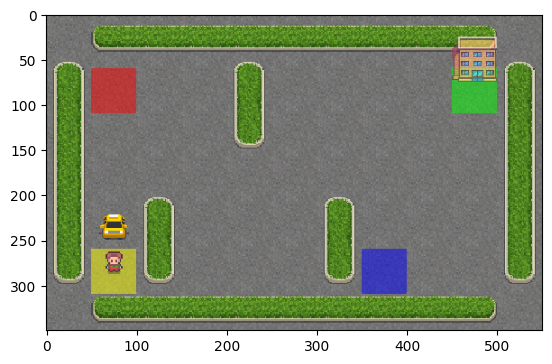

In [20]:
plt.imshow(env.render())

In [21]:
# Training parameters
env_id = "Taxi-v3"
n_training_episodes = 10000
alpha = 0.1
gamma = 1
eval_seed = []
n_eval_episodes = 100
max_steps = 200
max_epsilon = 1
min_epsilon = 0.05
decay_rate = 0.005
eval_seed = [16,54,165,177,191,191,120,80,149,178,48,38,6,125,174,73,50,172,100,148,146,6,25,40,68,148,49,167,9,97,164,176,61,7,54,55,
 161,131,184,51,170,12,120,113,95,126,51,98,36,135,54,82,45,95,89,59,95,124,9,113,58,85,51,134,121,169,105,21,30,11,50,65,12,43,82,145,152,97,106,55,31,85,38,
 112,102,168,123,97,21,83,158,26,80,63,5,81,32,11,28,148]

In [22]:
Q_Table = np.zeros((env.observation_space.n, env.action_space.n))

for episode in range(n_training_episodes):
    current_state, info = env.reset()
    
    for step in range(max_steps):
        action_mask = info["action_mask"]
        masked_q_values = np.where(action_mask == 1, Q_Table[current_state], -np.inf)
        
        action = np.argmax(masked_q_values)
        if np.random.rand() < epsilon:
            # Explore
            action = env.action_space.sample(action_mask)
            
        new_state, reward, terminated, truncated, info = env.step(action)
        Q_Table[current_state][action] += alpha*(reward + gamma*np.max(Q_Table[new_state]) - Q_Table[current_state][action])
        
        if truncated or terminated:
            break
            
        current_state = new_state
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)

In [23]:
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Q_Table, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")
print(f"HuggingFace Leaderboard score: {mean_reward-std_reward:.2f}")

Mean_reward=7.56 +/- 2.71
HuggingFace Leaderboard score: 4.85


In [24]:
record_video(env, Q_Table, "./Taxi.mp4")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x8921380] Warning: data is not aligned! This can lead to a speed loss


In [25]:
Video("./Taxi.mp4")

In [26]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,

    "learning_rate": alpha,
    "gamma": gamma,

    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,

    "qtable": Q_Table
}

In [27]:
username = "inventwithdean"
repo_name = "q-Taxi-v3"
push_to_hub(
    repo_id=f"{username}/{repo_name}",
    model=model,
    env=env)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

q-learning.pkl:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

results.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/739 [00:00<?, ?B/s]

replay.mp4:   0%|          | 0.00/119k [00:00<?, ?B/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


True


[swscaler @ 0x2ba723c0] Warning: data is not aligned! This can lead to a speed loss


q-learning.pkl:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

Your model is pushed to the Hub. You can view your model here:  https://huggingface.co/inventwithdean/q-Taxi-v3


In [28]:
from urllib.error import HTTPError

from huggingface_hub import hf_hub_download


def load_from_hub(repo_id: str, filename: str) -> str:
    """
    Download a model from Hugging Face Hub.
    :param repo_id: id of the model repository from the Hugging Face Hub
    :param filename: name of the model zip file from the repository
    """
    # Get the model from the Hub, download and cache the model on your local disk
    pickle_model = hf_hub_download(
        repo_id=repo_id,
        filename=filename
    )

    with open(pickle_model, 'rb') as f:
      downloaded_model_file = pickle.load(f)

    return downloaded_model_file

In [33]:
model = load_from_hub(repo_id="inventwithdean/q-Taxi-v3", filename="q-learning.pkl")

print(model)
env = gym.make(model["env_id"])

evaluate_agent(env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])

{'env_id': 'Taxi-v3', 'max_steps': 200, 'n_training_episodes': 10000, 'n_eval_episodes': 100, 'eval_seed': [16, 54, 165, 177, 191, 191, 120, 80, 149, 178, 48, 38, 6, 125, 174, 73, 50, 172, 100, 148, 146, 6, 25, 40, 68, 148, 49, 167, 9, 97, 164, 176, 61, 7, 54, 55, 161, 131, 184, 51, 170, 12, 120, 113, 95, 126, 51, 98, 36, 135, 54, 82, 45, 95, 89, 59, 95, 124, 9, 113, 58, 85, 51, 134, 121, 169, 105, 21, 30, 11, 50, 65, 12, 43, 82, 145, 152, 97, 106, 55, 31, 85, 38, 112, 102, 168, 123, 97, 21, 83, 158, 26, 80, 63, 5, 81, 32, 11, 28, 148], 'learning_rate': 0.1, 'gamma': 1, 'max_epsilon': 1, 'min_epsilon': 0.05, 'decay_rate': 0.005, 'qtable': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 3.68556364,  0.        ,  3.06137165,  0.        , 11.        ,
         0.        ],
       [ 9.87756937,  0.        , 10.86740709,  0.        , 15.        ,
         0.        ],
       ...,
       [ 0.        , 11.87363641,  0.        , -0.890581

(7.56, 2.706732347314747)